In [1]:
import os
import json
import numpy as np
import pandas as pd

from src.data_loader import Shifted_Data_Loader
import seaborn as sns
import matplotlib.pyplot as plt

    
from collections import Counter
import dit
from dit import Distribution
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
def load_config(run_dir,filename='config.json'):
    path = os.path.join(run_dir,filename)
    if os.path.exists(path):
        with open(path,'r') as config_json:
            conf = json.load(config_json)
        return conf

def load_model_spec(run_dir,filename='model.json'):
    path = os.path.join(run_dir,filename)

    if os.path.exists(path):
        with open(path,'r') as model_json:
            mod_spec = json.load(model_json)
            
        return mod_spec

def load_shifts(conf):
    np.random.seed(7)
    if conf['ecc_max'] == 0.0:
        tx_max = None
    else:
        tx_max = conf['ecc_max']
    DL = Shifted_Data_Loader(dataset=conf['dataset'],flatten=True,
                             rotation=None,
                             translation=tx_max,num_train=180000,
                            )
    return (DL.dx[1]-14,DL.dy[1]-14,DL.y_test)

def load_train_history(run_dir,conf,filename='train_history.parquet'):
    path = os.path.join(run_dir,filename)
    dirname,fname = os.path.split(path)
#     lab_corruption = np.round(float(dirname.split('/')[-1].split('_')[-1]),decimals=1)
#     arch = dirname.split('/')[-2]
    if conf is None:
        return None
    elif conf['recon'] == 0:
        arch = 'no_recon'
    else:
        arch = 'recon'

    if os.path.exists(path):
        hist = pd.read_parquet(path)
        hist['architecture'] = arch
        hist['label_corruption'] = conf['label_corruption']
        hist['ecc_max'] = conf['ecc_max']
        hist['xent'] = conf['xent']
        hist['recon'] = conf['recon']
        hist['epoch'] = list(hist.index.values*3)
#         hist['val_loss'] = sma(hist['val_loss'].values,win_size=3)
#         hist['loss'] = sma(hist['loss'].values,win_size=3)
        hist['val_dL'] = np.gradient(hist['val_loss'])
        hist['test_err'] = 1-hist['val_class_acc']
        hist['train_err'] = 1-hist['class_acc']
        hist['recon_gen_err'] = hist.G_loss - hist.val_G_loss
        hist['gen_err'] = hist.loss - hist.val_loss
        hist['class_gen_err'] = hist.class_loss - hist.val_class_loss
        hist['class_gen_acc'] = hist.class_acc - hist.val_class_acc

        return hist

def load_performance(run_dir, conf, th=None, filename='performance.json'):
    path = os.path.join(run_dir,filename)
#     dirname,fname = os.path.split(path)
#     arch = dirname.split('/')[-2]
    if conf is None:
        return None
    elif conf['recon'] == 0:
        arch = 'no_recon'
    else:
        arch = 'recon'

    if os.path.exists(path):
        with open(path, 'rb') as json:
            
            perf = pd.read_json(json)
            perf['architecture'] = arch

            perf['test_err'] = 1-perf['test_acc']
        if th is not None:
            perf['test_acc_max'] = th['val_class_acc'].values.max()
            perf['tt_overfit'] = np.argmax(th['val_class_acc'].values)
            tt_mem_bin_vec = (th['class_acc'].values<= 1-conf['label_corruption']).astype(int)
            perf['tt_memorization'] = tt_mem_bin_vec.sum()*3
            perf['test_err_min'] = 1-perf['test_acc_max']
            perf['test_acc_auc'] = np.trapz(th['val_class_acc'])
            perf['test_loss_auc'] = np.trapz(th['val_class_loss'],th['epoch'])
            perf['train_loss_auc'] = np.trapz(th['class_loss'])
        return perf
    


def mutual_information(X,Y):
    XY_c = Counter(zip(X,Y))
    XY_pmf = {k:v/float(sum(XY_c.values())) for k,v in XY_c.items()}
    XY_jdist = Distribution(XY_pmf)
        
    return dit.shannon.mutual_information(XY_jdist,[0],[1])

def load_I(rd,fn,conf,feat_range=(0,30)):
    
    dxs,dys,y_test = load_shifts(conf)
    z_enc = np.load(os.path.join(rd,fn))
    z_dim = z_enc.shape[-1]
    z_enc_scaled = [MinMaxScaler(feat_range).fit_transform(z_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(z_dim)]
    z_enc_scaled = np.squeeze(np.array(z_enc_scaled,dtype=int))
    z_dx_I = [mutual_information(z_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(z_dim)]
    z_dy_I = [mutual_information(z_enc_scaled[i],dys.astype(int)+14) for i in np.arange(z_dim)]
    z_class_I = [mutual_information(z_enc_scaled[i],y_test) for i in np.arange(z_dim)]
    z_I_df = pd.DataFrame.from_records({'class':z_class_I,'dy':z_dy_I,'dx':z_dx_I})
    z_I_df['class'] = z_I_df['class'].values.round(decimals=1)
    z_I_df['ecc_max'] = conf['ecc_max']
    z_I_df['recon'] = conf['recon']
    z_I_df['xent'] = conf['xent']
    z_I_df['label_corruption'] = conf['label_corruption']
    
    return z_I_df
#     y_enc = np.load(os.path.join(rd,'y_enc.npy'))
#     y_dim = y_enc.shape[-1]
#     y_enc_scaled = [MinMaxScaler(feat_range).fit_transform(y_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(y_dim)]
#     y_enc_scaled = np.squeeze(np.array(y_enc_scaled,dtype=int))
    
    

In [3]:
exp_root = '/home/elijahc/projects/vae/models/2019-05-07'
runs = []
for branches in os.listdir(exp_root):
    for leaf in os.listdir(os.path.join(exp_root,branches)):
        runs.append(os.path.join(exp_root,branches,leaf))

runs = list(filter(lambda x: 'ipynb_checkpoints' not in x,runs))
configs = [load_config(rd) for rd in runs]
train_historys = [load_train_history(rd,conf) for rd,conf in zip(runs,configs)]
perf = [load_performance(rd,conf,th) for rd,conf,th in zip(runs,configs,train_historys)]
model_specs = [load_model_spec(rd) for rd in runs]

In [4]:
perf_df = pd.concat(perf)

In [5]:
def load_variations(conf):
    _,_,y_te = load_shifts(conf)
    return y_te

In [69]:
shifts = [load_shifts(c) for c in configs]

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.2
rot_max:  None
bg_noise: None
loading fashion_mnist...
sx_train:  (180000, 3136)
making training data...
making testing data...
input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
bg_noise: None
loading fashion_mnist...
sx_train:  (180000, 3136)
making training data...
making testing data...
input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
bg_noise: None
loading fashion_mnist...
sx_train:  (180000, 3136)
making training data...
making testing data...
input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
bg_noise: None
loading fashion_mnist...
sx_train:  (180000, 3136)
making training data...
making testing data...
input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
bg_noise: None
loading fashion_mnist...
sx_train:  (180000, 3136)
making training data...
making testing data...
input_shape:  (

In [70]:
dxs = [s[0] for s in shifts]
dys = [s[1] for s in shifts]
y_tes = [s[2] for s in shifts]

In [71]:
y_encs = [np.load(os.path.join(rd,'y_enc.npy')) for rd in runs]
z_encs = [np.load(os.path.join(rd,'z_enc.npy')) for rd in runs]

y_enc_dfs = [pd.DataFrame(data=ye,columns=['y{}'.format(i) for i in np.arange(10)]) for ye in y_encs]
z_enc_dfs = [pd.DataFrame(data=ze,columns=['z{}'.format(i) for i in np.arange(5)]) for ze in z_encs]

In [72]:
l2_encs = [np.load(os.path.join(rd,'l2_enc.npy')) for rd in runs]
l2_enc_dfs = [pd.DataFrame(data=l2e,columns=['l2_{}'.format(i) for i in np.arange(2000)]) for l2e in l2_encs]

In [73]:
l1_encs = [np.load(os.path.join(rd,'l1_enc.npy')) for rd in runs]
l1_enc_dfs = [pd.DataFrame(data=l1e,columns=['l1_{}'.format(i) for i in np.arange(3000)]) for l1e in l1_encs]

In [74]:
def conf_fetch(configs,key):
    return [conf[key] for conf in configs]

In [75]:
for y_te,dx,dy,df,zdf,l2df,l1df in zip(y_tes,dxs,dys,y_enc_dfs,z_enc_dfs,l2_enc_dfs,l1_enc_dfs):
    df['class'] = y_te
    zdf['class'] = y_te
    l2df['class'] = y_te
    l1df['class'] = y_te
    
    df['dx'] = dx
    zdf['dx'] = dx
    l2df['dx'] = dx
    l1df['dx'] = dx
    
    df['dy'] = dy
    zdf['dy'] = dy
    l2df['dy'] = dy
    l1df['dy'] = dy

In [107]:
def dicarlo_sel(df,num_units=10,col='class'):
    mu = df.groupby(col).mean().values[:,:num_units]
    var = df.groupby(col).var().values[:,:num_units]

    mu_max_idxs = np.argmax(mu,axis=0)
    mu_min_idxs = np.argmin(mu,axis=0)

    mu_max = np.array([mu[maxi,i] for i,maxi in zip(np.arange(len(mu_max_idxs)),mu_max_idxs)])
    mu_min = np.array([mu[maxi,i] for i,maxi in zip(np.arange(len(mu_min_idxs)),mu_min_idxs)])
    
    var_b = np.array([var[maxi,i] for i,maxi in zip(np.arange(len(mu_max_idxs)),mu_max_idxs)])
    var_w = np.array([var[mini,i] for i,mini in zip(np.arange(len(mu_min_idxs)),mu_min_idxs)])
#     neg_max = [(allv-mu_max)/9.0 for allv,mu_max in zip(all_vals.sum(axis=1),mu_max)]
    
    sel = [(mu_b-mu_w)/np.sqrt((vb+vw)/2) for mu_b,mu_w,vb,vw in zip(mu_max,mu_min,var_b,var_w)]
    return sel

In [111]:
y_c_arr = np.array([dicarlo_sel(df,num_units=10) for df in y_enc_dfs])
y_c_sel = pd.DataFrame(y_c_arr,columns=['y{}'.format(i) for i in np.arange(10)])
y_c_sel['xent'] = conf_fetch(configs,'xent')
y_c_sel['recon'] = conf_fetch(configs,'recon')
y_c_sel['label_corruption'] = conf_fetch(configs,'label_corruption')
y_c_sel['ecc_max'] = conf_fetch(configs,'ecc_max')
y_c_sel['layer_depth'] = 3
y_c_sel['layer_name'] = 'y'

y_x_sel = np.array([dicarlo_sel(df,col='dx',num_units=10) for df in y_enc_dfs])
y_x_sel = pd.DataFrame(y_x_sel,columns=['y{}'.format(i) for i in np.arange(10)])
y_x_sel['xent'] = conf_fetch(configs,'xent')
y_x_sel['recon'] = conf_fetch(configs,'recon')
y_x_sel['label_corruption'] = conf_fetch(configs,'label_corruption')
y_x_sel['ecc_max'] = conf_fetch(configs,'ecc_max')
y_x_sel['layer_depth'] = 3
y_x_sel['layer_name'] = 'y'

y_y_sel = np.array([dicarlo_sel(df,col='dy',num_units=10) for df in y_enc_dfs])
y_y_sel = pd.DataFrame(y_y_sel,columns=['y{}'.format(i) for i in np.arange(10)])
y_y_sel['xent'] = conf_fetch(configs,'xent')
y_y_sel['recon'] = conf_fetch(configs,'recon')
y_y_sel['label_corruption'] = conf_fetch(configs,'label_corruption')
y_y_sel['ecc_max'] = conf_fetch(configs,'ecc_max')
y_y_sel['layer_depth'] = 3
y_y_sel['layer_name'] = 'y'


In [129]:
z_c_arr = np.nan_to_num(np.array([dicarlo_sel(df,num_units=5) for df in z_enc_dfs]))
z_c_sel = pd.DataFrame(z_c_arr,columns=['z{}'.format(i) for i in np.arange(5)])
z_c_sel['xent'] = conf_fetch(configs,'xent')
z_c_sel['recon'] = conf_fetch(configs,'recon')
z_c_sel['label_corruption'] = conf_fetch(configs,'label_corruption')
z_c_sel['ecc_max'] = conf_fetch(configs,'ecc_max')
z_c_sel['layer_depth'] = 3
z_c_sel['layer_name'] = 'z'

z_x_sel = np.array([dicarlo_sel(df,col='dx',num_units=5) for df in z_enc_dfs])
z_x_sel = pd.DataFrame(z_x_sel,columns=['z{}'.format(i) for i in np.arange(5)])
z_x_sel['xent'] = conf_fetch(configs,'xent')
z_x_sel['recon'] = conf_fetch(configs,'recon')
z_x_sel['label_corruption'] = conf_fetch(configs,'label_corruption')
z_x_sel['ecc_max'] = conf_fetch(configs,'ecc_max')
z_x_sel['layer_depth'] = 3
z_x_sel['layer_name'] = 'z'

In [130]:
l2_c_arr = np.nan_to_num(np.array([dicarlo_sel(df,num_units=2000) for df in l2_enc_dfs]))
l2_c_sel = pd.DataFrame(l2_c_arr,columns=['l2_{}'.format(i) for i in np.arange(2000)])
l2_c_sel['xent'] = conf_fetch(configs,'xent')
l2_c_sel['recon'] = conf_fetch(configs,'recon')
l2_c_sel['label_corruption'] = conf_fetch(configs,'label_corruption')
l2_c_sel['ecc_max'] = conf_fetch(configs,'ecc_max')
l2_c_sel['layer_depth'] = 2
l2_c_sel['layer_name'] = 'l2'

l2_x_arr = np.nan_to_num(np.array([dicarlo_sel(df,col='dx',num_units=2000) for df in l2_enc_dfs]))
l2_x_sel = pd.DataFrame(l2_x_arr,columns=['l2_{}'.format(i) for i in np.arange(2000)])
l2_x_sel['xent'] = conf_fetch(configs,'xent')
l2_x_sel['recon'] = conf_fetch(configs,'recon')
l2_x_sel['label_corruption'] = conf_fetch(configs,'label_corruption')
l2_x_sel['ecc_max'] = conf_fetch(configs,'ecc_max')
l2_x_sel['layer_depth'] = 2
l2_x_sel['layer_name'] = 'l2'

In [131]:
l1_c_arr = np.nan_to_num(np.array([dicarlo_sel(df,num_units=3000) for df in l1_enc_dfs]))
l1_c_sel = pd.DataFrame(l1_c_arr,columns=['l1_{}'.format(i) for i in np.arange(3000)])
l1_c_sel['xent'] = conf_fetch(configs,'xent')
l1_c_sel['recon'] = conf_fetch(configs,'recon')
l1_c_sel['label_corruption'] = conf_fetch(configs,'label_corruption')
l1_c_sel['ecc_max'] = conf_fetch(configs,'ecc_max')
l1_c_sel['layer_depth'] = 1
l1_c_sel['layer_name'] = 'l1'

l1_x_arr = np.nan_to_num(np.array([dicarlo_sel(df,num_units=3000) for df in l1_enc_dfs]))
l1_x_sel = pd.DataFrame(l1_x_arr,columns=['l1_{}'.format(i) for i in np.arange(3000)])
l1_x_sel['xent'] = conf_fetch(configs,'xent')
l1_x_sel['recon'] = conf_fetch(configs,'recon')
l1_x_sel['label_corruption'] = conf_fetch(configs,'label_corruption')
l1_x_sel['ecc_max'] = conf_fetch(configs,'ecc_max')
l1_x_sel['layer_depth'] = 1
l1_x_sel['layer_name'] = 'l1'

In [132]:
z_c_sel_df = pd.melt(z_c_sel,id_vars=['xent','recon','label_corruption','ecc_max','layer_depth','layer_name'],value_name='class_selectivity',var_name='unit')
y_c_sel_df = pd.melt(y_c_sel,id_vars=['xent','recon','label_corruption','ecc_max','layer_depth','layer_name'],value_name='class_selectivity',var_name='unit')
l2_c_sel_df = pd.melt(l2_c_sel,id_vars=['xent','recon','label_corruption','ecc_max','layer_depth','layer_name'],value_name='class_selectivity',var_name='unit')
l1_c_sel_df = pd.melt(l1_c_sel,id_vars=['xent','recon','label_corruption','ecc_max','layer_depth','layer_name'],value_name='class_selectivity',var_name='unit')

all_c_df = pd.concat([z_c_sel_df,y_c_sel_df,l2_c_sel_df,l1_c_sel_df])

z_x_sel_df = pd.melt(z_x_sel,id_vars=['xent','recon','label_corruption','ecc_max','layer_depth','layer_name'],value_name='dx_selectivity',var_name='unit')
y_x_sel_df = pd.melt(y_x_sel,id_vars=['xent','recon','label_corruption','ecc_max','layer_depth','layer_name'],value_name='dx_selectivity',var_name='unit')
l2_x_sel_df = pd.melt(l2_x_sel,id_vars=['xent','recon','label_corruption','ecc_max','layer_depth','layer_name'],value_name='dx_selectivity',var_name='unit')
l1_x_sel_df = pd.melt(l1_x_sel,id_vars=['xent','recon','label_corruption','ecc_max','layer_depth','layer_name'],value_name='dx_selectivity',var_name='unit')

all_x_df = pd.concat([z_x_sel_df,y_x_sel_df,l2_x_sel_df,l1_x_sel_df])

In [133]:
all_x_df.head()

,xent,recon,label_corruption,ecc_max,layer_depth,layer_name,unit,dx_selectivity
0,15,25,0.0,0.2,3,z,z0,1.248085
1,15,25,0.4,0.8,3,z,z0,3.024786
2,15,25,0.8,0.8,3,z,z0,3.085548
3,15,25,0.0,0.8,3,z,z0,1.603792
4,15,25,0.6,0.8,3,z,z0,4.148852


/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


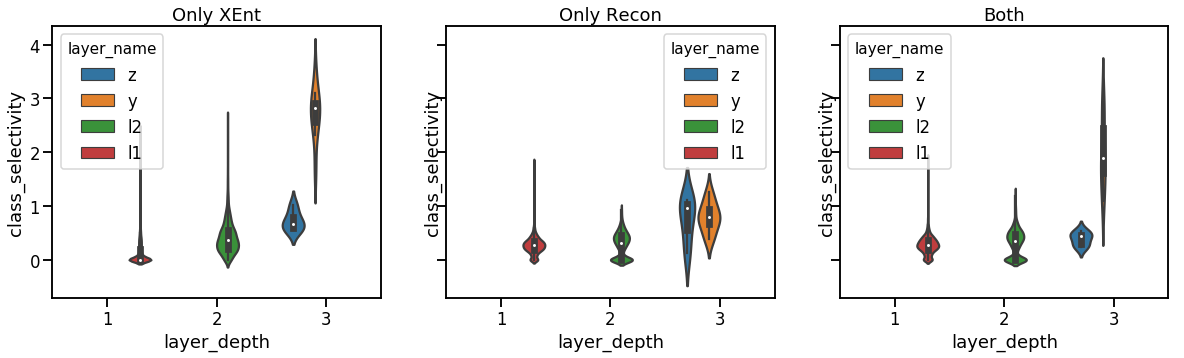

In [134]:
fig,axs = plt.subplots(1,3,figsize=(20,5),sharey=True)
queries = [
    'label_corruption == 0.0 & xent == 15 & recon == 0 & ecc_max == 0.8',
    'label_corruption == 0.0 & xent == 0 & recon == 25 & ecc_max == 0.8',
    'label_corruption == 0.0 & xent == 15 & recon == 25 & ecc_max == 0.8',
          ]
titles = ['Only XEnt','Only Recon','Both']
sns.set_context('talk')
for ax,q,title in zip(axs,queries,titles): 
    sns.violinplot(y='class_selectivity',x='layer_depth',hue='layer_name',data=all_c_df.query(q),ax=ax)
    ax.set_title(title)

# Dx Selectivity Results by layer

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


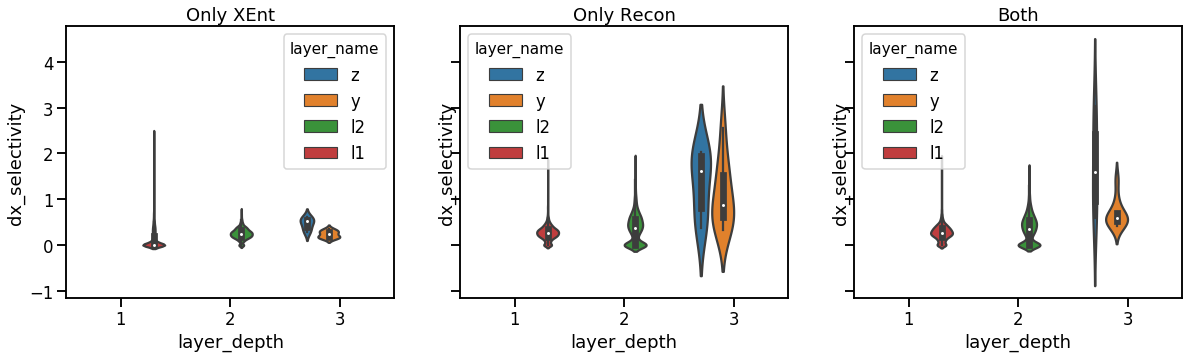

In [137]:
fig,axs = plt.subplots(1,3,figsize=(20,5),sharey=True)
queries = [
    'label_corruption == 0.0 & xent == 15 & recon == 0 & ecc_max == 0.8',
    'label_corruption == 0.0 & xent == 0 & recon == 25 & ecc_max == 0.8',
    'label_corruption == 0.0 & xent == 15 & recon == 25 & ecc_max == 0.8',
          ]
titles = ['Only XEnt','Only Recon','Both']
sns.set_context('talk')
for ax,q,title in zip(axs,queries,titles): 
    sns.violinplot(y='dx_selectivity',x='layer_depth',hue='layer_name',data=all_x_df.query(q),ax=ax)
    ax.set_title(title)

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'No XEnt')

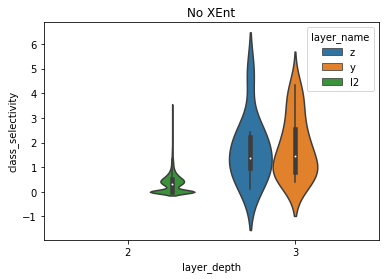

In [34]:
sns.violinplot(y='class_selectivity',x='layer_depth',hue='layer_name',data=all_df.query('label_corruption == 0.0 & xent == 0 & recon == 25'))
plt.title('No XEnt')

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Both')

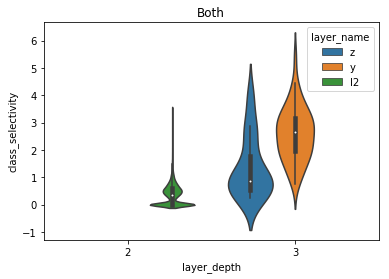

In [35]:
sns.violinplot(y='class_selectivity',x='layer_depth',hue='layer_name',data=all_df.query('label_corruption == 0.0 & xent == 15 & recon == 25'))
plt.title('Both')

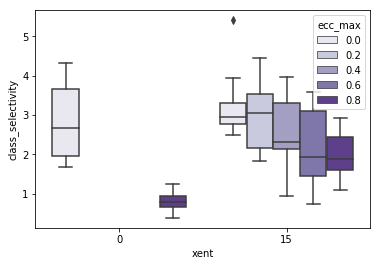

In [19]:
sns.boxplot(y='class_selectivity',x='xent',hue='ecc_max',data=y_sel_df.query('label_corruption == 0.0 & recon == 25'),palette='Purples')

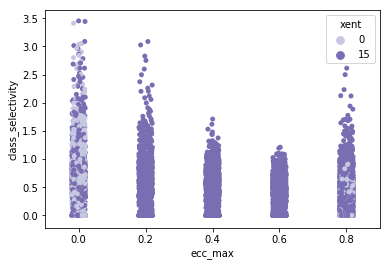

In [20]:
sns.stripplot(y='class_selectivity',x='ecc_max',hue='xent',data=l2_sel_df.query('label_corruption == 0.0'),palette='Purples')

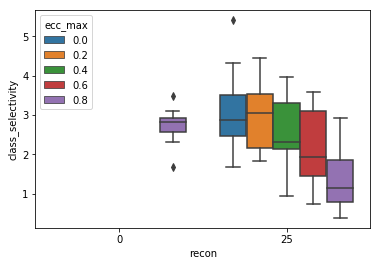

In [21]:
sns.boxplot(y='class_selectivity',x='recon',hue='ecc_max',data=y_sel_df.query('label_corruption == 0.0'))

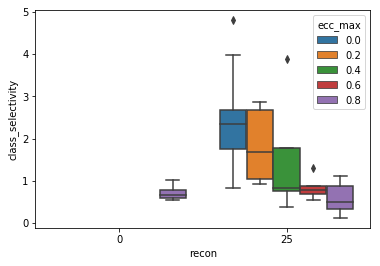

In [22]:
sns.boxplot(y='class_selectivity',x='recon',hue='ecc_max',data=z_sel_df.query('label_corruption == 0.0'))

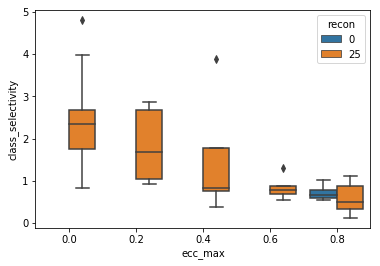

In [23]:
sns.boxplot(y='class_selectivity',x='ecc_max',hue='recon',data=z_sel_df.query('label_corruption == 0.0'))

In [24]:
conf_fetch(configs,'xent')

[15, 15, 15, 15, 15, 15, 0, 0, 15, 15, 15, 15, 15]

In [25]:
len(configs)

13